In [82]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [83]:
languages = ['nodejs', 'java', 'graal', 'go', 'posix', 'arduino_due']
log_modes = ['monitor', 'monitor-bin']
modes = ['no', 'off', 'on']
fig_counter = 0
root='../../../src-gen/logs'

In [84]:
def allFiles(language, mode, log_mode):
    directory = os.fsencode(root + '/' + log_mode + '/' + mode)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.split('-')[1] == language and filename.endswith('.log'): 
            yield root + '/' + log_mode + '/' + mode + '/' + filename
            
def loadMemory(filename, language):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break
        #if language == 'go':
        #    line = line[20:]
        if '>usedMem:' in line:
            mem = int(line[1:].strip().split(':')[1:][0])
            yield mem   
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break                  
        if '>done in ' in line:
            time = int(line.split('>')[1][8:-4])
            return time

In [85]:
def allData(language, mode, log_mode):
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, log_mode):
        mem = np.array(list(loadMemory(filename, language))).astype(int).flatten()
        t = loadTotalTime(filename)
        all_mem.append(mem)
        all_t.append(t)
    return all_mem, all_t

Processing nodejs no monitor...
mean mem:    3355720.0, mean t:    4011.0
median mem:  3346328.0, median t:  4005.5
Processing nodejs off monitor...
mean mem:    3887419.2, mean t:    4050.3
median mem:  3884176.0, median t:  4048.0
Processing nodejs on monitor...
mean mem:    4064460.8, mean t:    4673.0
median mem:  4064244.0, median t:  4661.5


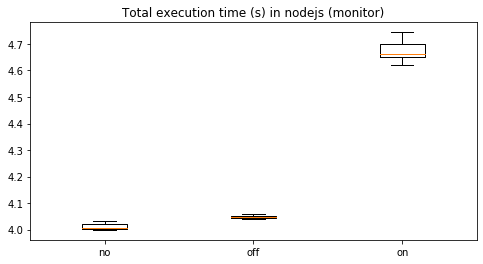

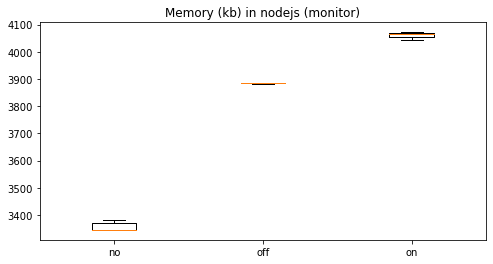

Processing java no monitor...
mean mem:    714734.4, mean t:    3927.2
median mem:  714644.0, median t:  3925.0
Processing java off monitor...
mean mem:    747296.8, mean t:    4322.8
median mem:  747188.0, median t:  4333.0
Processing java on monitor...
mean mem:    750022.4, mean t:    4019.3
median mem:  750040.0, median t:  4020.0


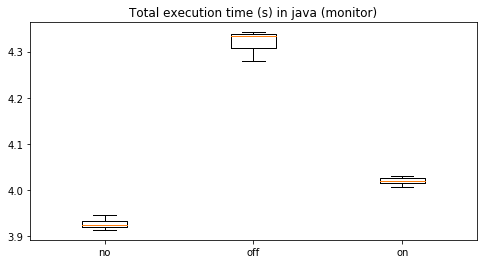

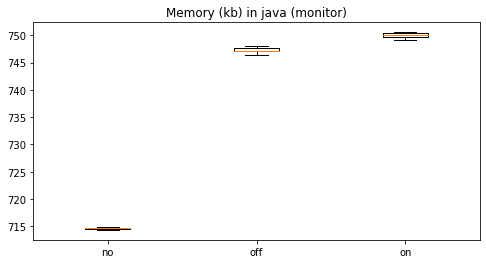

Processing graal no monitor...
mean mem:    2093008.0, mean t:    3897.2
median mem:  2093008.0, median t:  3890.0
Processing graal off monitor...
mean mem:    2093008.0, mean t:    4313.5
median mem:  2093008.0, median t:  4315.5
Processing graal on monitor...
mean mem:    2093008.0, mean t:    3978.4
median mem:  2093008.0, median t:  3977.0


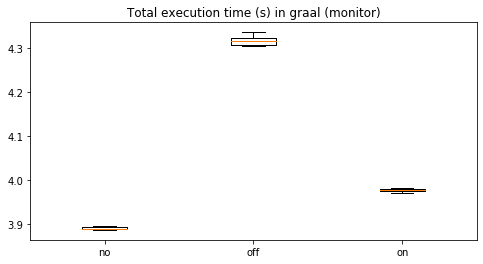

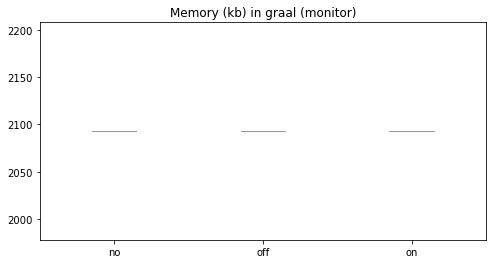

Processing go no monitor...
mean mem:    185332.8, mean t:    3846.0
median mem:  184872.0, median t:  3845.0
Processing go off monitor...
mean mem:    196347.2, mean t:    3873.9
median mem:  193168.0, median t:  3874.0
Processing go on monitor...
mean mem:    206848.8, mean t:    3883.0
median mem:  206324.0, median t:  3882.5


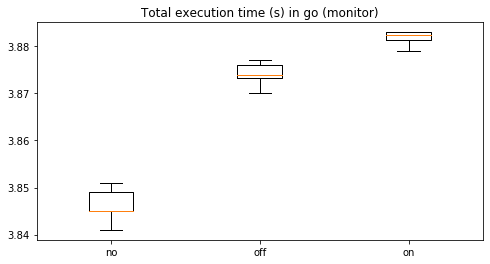

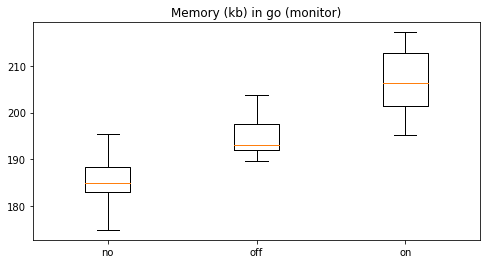

Processing posix no monitor...
mean mem:    3053.0, mean t:    4993.8
median mem:  3053.0, median t:  4992.5
Processing posix off monitor...
Processing posix off monitor: Error!
Processing arduino_due no monitor...
mean mem:    4625.0, mean t:    4880.0
median mem:  4625.0, median t:  4880.0
Processing arduino_due off monitor...
mean mem:    8897.0, mean t:    14297.0
median mem:  8897.0, median t:  14297.0
Processing arduino_due on monitor...
mean mem:    8897.0, mean t:    92011.0
median mem:  8897.0, median t:  92011.0


C:\Users\brice\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\brice\Miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


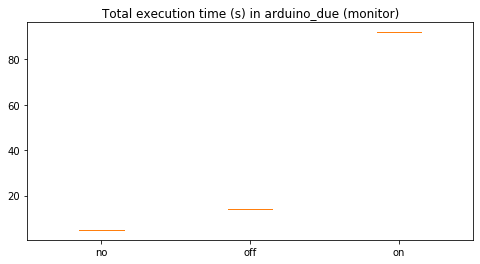

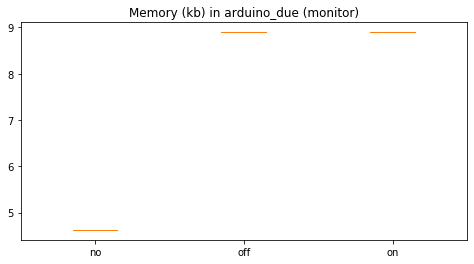

Processing nodejs no monitor-bin...
mean mem:    3384848.8, mean t:    4008.1
median mem:  3373576.0, median t:  4008.0
Processing nodejs off monitor-bin...
mean mem:    3657198.4, mean t:    4040.6
median mem:  3654228.0, median t:  4041.5
Processing nodejs on monitor-bin...
mean mem:    4035712.0, mean t:    5258.7
median mem:  4032472.0, median t:  5266.0


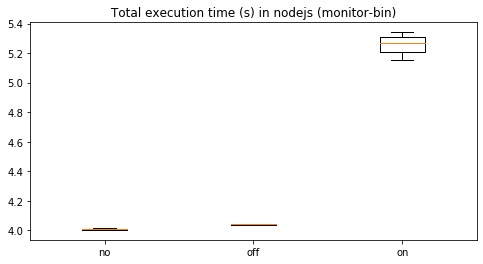

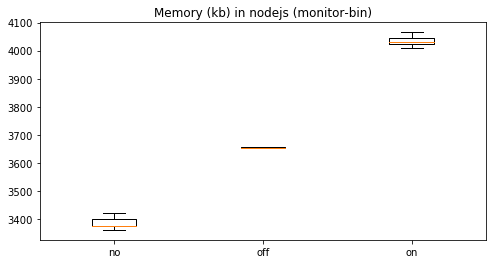

Processing java no monitor-bin...
mean mem:    714764.8, mean t:    3928.5
median mem:  714608.0, median t:  3927.0
Processing java off monitor-bin...
mean mem:    735758.4, mean t:    4269.4
median mem:  735016.0, median t:  4271.5
Processing java on monitor-bin...
mean mem:    738346.4, mean t:    3989.4
median mem:  738484.0, median t:  3992.0


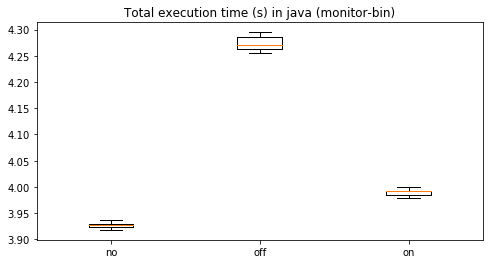

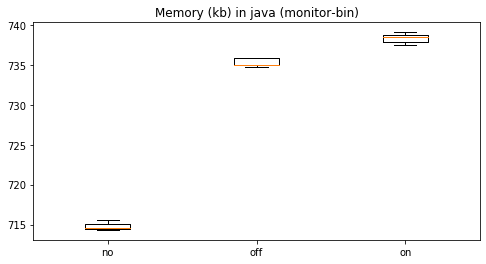

Processing graal no monitor-bin...
mean mem:    2093008.0, mean t:    3890.9
median mem:  2093008.0, median t:  3891.0
Processing graal off monitor-bin...
mean mem:    2093008.0, mean t:    4269.6
median mem:  2093008.0, median t:  4273.0
Processing graal on monitor-bin...
mean mem:    2093008.0, mean t:    3955.4
median mem:  2093008.0, median t:  3955.5


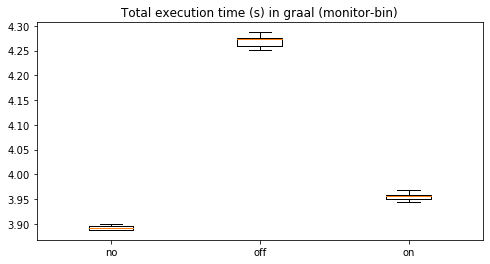

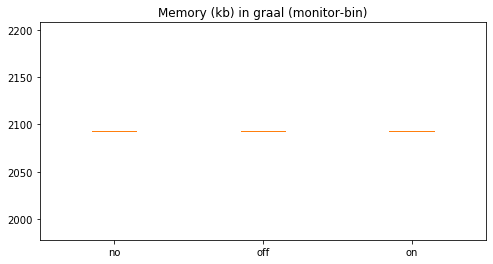

Processing go no monitor-bin...
mean mem:    188129.6, mean t:    3843.4
median mem:  186984.0, median t:  3842.0
Processing go off monitor-bin...
mean mem:    193660.8, mean t:    3853.8
median mem:  192472.0, median t:  3852.0
Processing go on monitor-bin...
mean mem:    185062.4, mean t:    3864.5
median mem:  186312.0, median t:  3863.5


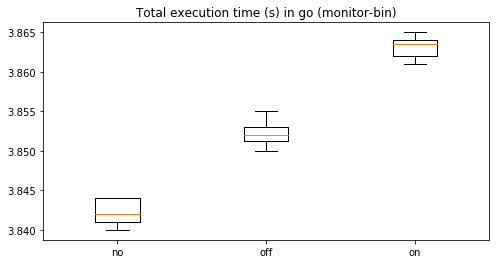

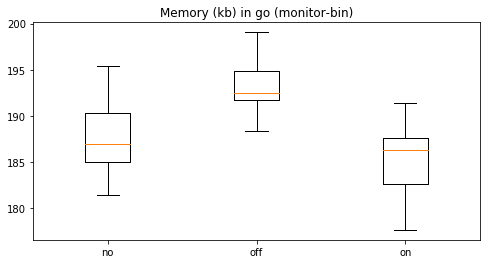

Processing posix no monitor-bin...
mean mem:    3053.0, mean t:    4993.5
median mem:  3053.0, median t:  4993.5
Processing posix off monitor-bin...
mean mem:    3058.0, mean t:    4991.7
median mem:  3058.0, median t:  4992.0
Processing posix on monitor-bin...
mean mem:    3058.0, mean t:    4996.4
median mem:  3058.0, median t:  4996.0


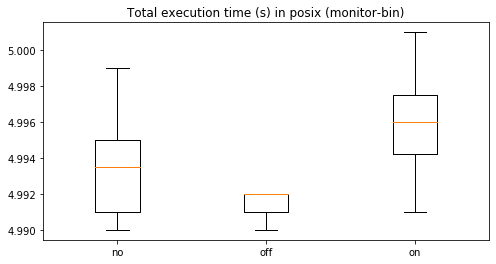

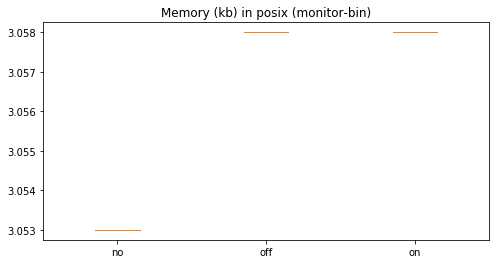

Processing arduino_due no monitor-bin...
mean mem:    4625.0, mean t:    4880.0
median mem:  4625.0, median t:  4880.0
Processing arduino_due off monitor-bin...
mean mem:    4885.0, mean t:    4880.0
median mem:  4885.0, median t:  4880.0
Processing arduino_due on monitor-bin...
mean mem:    4885.0, mean t:    19785.0
median mem:  4885.0, median t:  19785.0


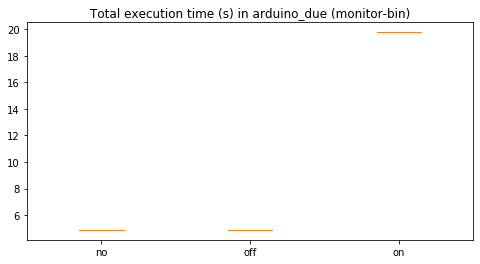

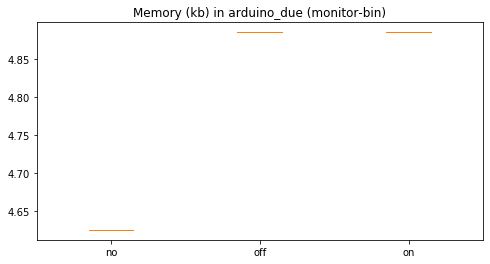

In [86]:
for log_mode in log_modes:
    global fig_counter
    for language in languages:            
        all_t = []
        all_mem = []
        hasError = False
        for mode in modes:
            try:
                print('Processing ' + language + ' ' + mode + ' ' + log_mode + '...')
                mem, t = allData(language, mode, log_mode)
                print('mean mem:    ' + str(np.mean(mem)) + ', mean t:    ' + str(np.mean(t)))            
                print('median mem:  ' + str(np.median(mem)) + ', median t:  ' + str(np.median(t)))
                all_t.append(np.array(t).flatten()/1000)
                all_mem.append(np.array(mem).flatten()/1000)
            except TypeError:
                print('Processing ' + language + ' ' + mode + ' ' + log_mode + ': Error!')
                hasError = True
                break
        
        if hasError:
            continue
            
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_t, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Total execution time (s) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_mem, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Memory (kb) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    

Processing posix on monitor: Error!


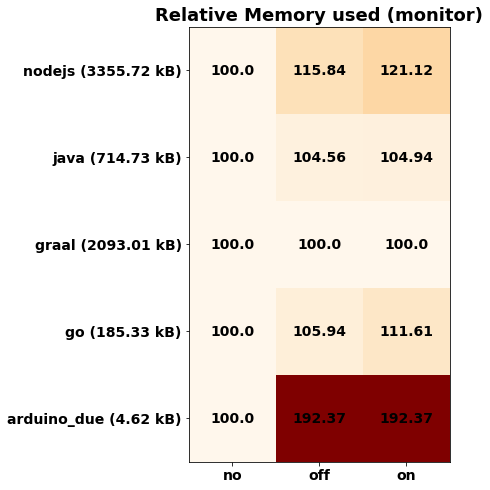

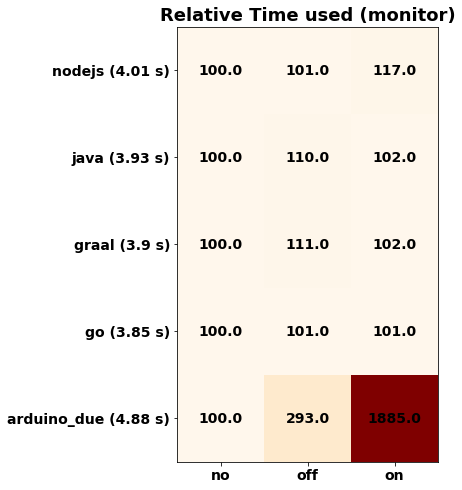

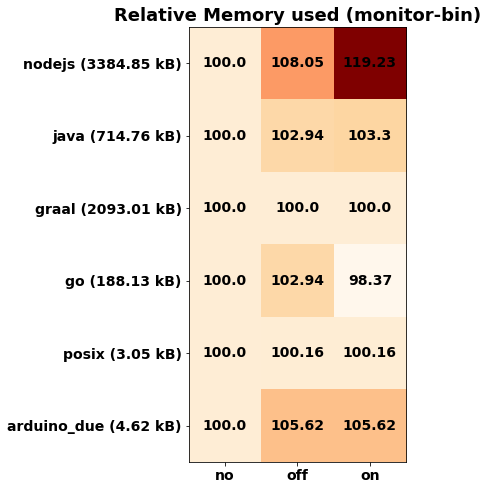

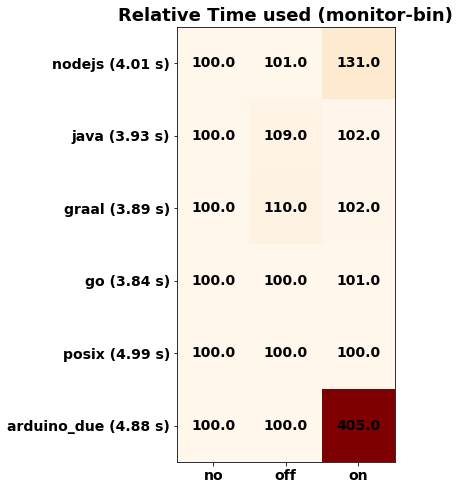

In [89]:
def mem_t_by_language(language, log_mode):
    all_t = []
    all_mem = []
    for mode in modes:
#         print('Processing ' + language + ' ' + mode + ' ' + log_mode + '...')
        mem, t = allData(language, mode, log_mode)
        all_t.append(np.mean(t))
        all_mem.append(np.mean(mem))
#     print(all_t)
#     print(all_mem)
    return all_mem, all_t

for log_mode in log_modes:
    global fig_counter
    all_t = []
    all_mem = []
    valid_lang_mem = []
    valid_lang_t = []
    for language in languages:                    
        hasError = False
        try:                
            mem, t = mem_t_by_language(language, log_mode)
            all_t.append(np.round(np.array(t)/t[0]*100,0))
            all_mem.append(np.round(np.array(mem)/mem[0]*100,2))
        except TypeError:
            print('Processing ' + language + ' ' + mode + ' ' + log_mode + ': Error!')
            hasError = True
        if not hasError:
            valid_lang_mem.append(language + ' (' + str(round(mem[0]/1000,2)) + ' kB)')
            valid_lang_t.append(language + ' (' + str(round(t[0]/1000,2)) + ' s)')
            
    
#     print(np.array(all_t).shape)
#     print(np.array(all_t))
#     print(np.array(all_mem).shape)
#     print(np.array(all_mem))
    
    fig = plt.figure(fig_counter, figsize=(10,8))        
    plt.imshow(all_mem, cmap='OrRd')
    plt.xticks(range(0, 3), ('no', 'off', 'on'), weight='heavy', fontsize=14)
    plt.yticks(range(0, len(valid_lang_mem)), valid_lang_mem, weight='heavy', fontsize=14)
    for x_val in range(0, 3):
        for y_val in range(0, len(valid_lang_mem)):
            c = all_mem[y_val][x_val]
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
    plt.title('Relative Memory used (' + log_mode + ')', weight='heavy', fontsize=18)
    plt.show()  
    fig_counter = fig_counter + 1
    
    fig = plt.figure(fig_counter, figsize=(10,8))        
    plt.imshow(all_t, cmap='OrRd')
    plt.xticks(range(0, 3), ('no', 'off', 'on'), weight='heavy', fontsize=14)
    plt.yticks(range(0, len(valid_lang_t)), valid_lang_t, weight='heavy', fontsize=14)
    for x_val in range(0, 3):
        for y_val in range(0, len(valid_lang_t)):
            c = all_t[y_val][x_val]
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
    plt.title('Relative Time used (' + log_mode + ')', weight='heavy', fontsize=18)
    plt.show()  
    fig_counter = fig_counter + 1
    